# Variation du salaire de base

Initialisations Python

In [1]:
from datetime import date
import matplotlib.pyplot as plt
#importer numpy permet de coler deux sections de courbes (nécessaire quand on fait varier le salaire de base en-dessous du SMIC mensuel)
import numpy as np
from numpy import logical_not as not_, minimum as min_, maximum as max_, logical_and as and_, logical_or as or_, round as round_

%matplotlib inline

import json
import openfisca_france
from openfisca_france.model.base import *

# to debug / trace
from openfisca_core import tools
from openfisca_core.reforms import Reform



Initialisations OpenFisca

In [2]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()

In [3]:
def modify_legislation_json(reference_legislation_json_copy):
    return reference_legislation_json_copy


In [4]:
class allegement_fillon(DatedVariable):
    column = FloatCol
    entity_class = Individus
    label = u"Allègement de charges employeur sur les bas et moyens salaires (dit allègement Fillon)"

    # Attention : cet allègement a des règles de cumul spécifiques

    @dated_function(date(2005, 7, 1))
    
    def function(self, simulation, period):
        period = period.this_month
        stagiaire = simulation.calculate('stagiaire', period)
        apprenti = simulation.calculate('apprenti', period)
        allegement_mode_recouvrement = simulation.calculate('allegement_fillon_mode_recouvrement', period)

        # switch on 3 possible payment options
        allegement = switch_on_allegement_mode(
            simulation, period,
            allegement_mode_recouvrement,
            self.__class__.__name__,
        )
        
           
        return period, allegement * not_(stagiaire) * not_(apprenti)
    
def compute_allegement_fillon(simulation, period):
    """
    Exonération Fillon
    http://www.securite-sociale.fr/comprendre/dossiers/exocotisations/exoenvigueur/fillon.htm
    """
       
    assiette = simulation.calculate_add('assiette_allegement', period)
    smic_proratise = simulation.calculate_add('smic_proratise', period)
    taille_entreprise = simulation.calculate('taille_entreprise', period)
    majoration = (taille_entreprise <= 2)  # majoration éventuelle pour les petites entreprises
    # Calcul du taux
    # Le montant maximum de l’allègement dépend de l’effectif de l’entreprise.
    # Le montant est calculé chaque année civile, pour chaque salarié ;
    # il est égal au produit de la totalité de la rémunération annuelle telle
    # que visée à l’article L. 242-1 du code de la Sécurité sociale par un
    # coefficient.
    # Ce montant est majoré de 10 % pour les entreprises de travail temporaire
    # au titre des salariés temporaires pour lesquels elle est tenue à
    # l’obligation d’indemnisation compensatrice de congés payés.
    Pf = simulation.legislation_at(period.start).cotsoc.exo_bas_sal.fillon
    seuil = Pf.seuil
    tx_max = (Pf.tx_max * not_(majoration) + Pf.tx_max2 * majoration)
    
    
    if seuil <= 1:    
        return 0
    
    ratio_smic_salaire = smic_proratise / (assiette + 1e-16)
    # règle d'arrondi: 4 décimales au dix-millième le plus proche
    
    import pdb; pdb.set_trace()
    
    taux_fillon = round_(tx_max * min_(1, max_(seuil * ratio_smic_salaire - 1, 0) / (seuil - 1)), 4)
    
    
    
    # Montant de l'allegment
    return taux_fillon * assiette

 

def switch_on_allegement_mode(simulation, period, mode_recouvrement, variable_name):
    """
        Switch on 3 possible payment options for allegements
        Name of the computation method specific to the allegement
        should precisely be the variable name prefixed with 'compute_'
    """
    compute_function = globals()['compute_' + variable_name]
    return switch(
        mode_recouvrement,
        {
            0: compute_allegement_annuel(simulation, period, variable_name, compute_function),
            1: compute_allegement_anticipe(simulation, period, variable_name, compute_function),
            2: compute_allegement_progressif(simulation, period, variable_name, compute_function),
                     
        },
        
     )



def compute_allegement_annuel(simulation, period, variable_name, compute_function):
    if period.start.month < 12:
        return 0
    if period.start.month == 12:
        return compute_function(simulation, period.this_year)


def compute_allegement_anticipe(simulation, period, variable_name, compute_function):
    if period.start.month < 12:
        return compute_function(simulation, period.this_month)
    if period.start.month == 12:
        cumul = simulation.calculate_add(
            variable_name,
            period.start.offset('first-of', 'year').period('month', 11), max_nb_cycles=1)
        return compute_function(
            simulation, period.this_year
        ) - cumul


def compute_allegement_progressif(simulation, period, variable_name, compute_function):
    if period.start.month == 1:
        return compute_function(simulation, period.this_month)

    if period.start.month > 1:
        up_to_this_month = period.start.offset('first-of', 'year').period('month', period.start.month)
        up_to_previous_month = period.start.offset('first-of', 'year').period('month', period.start.month - 1)
        cumul = simulation.calculate_add(variable_name, up_to_previous_month, max_nb_cycles=1)
        return compute_function(simulation, up_to_this_month) - cumul


In [5]:
class Modification_Calcul_Allegement_Fillon(Reform):
    name = u"Modification du Calcul de l'Allègement Fillon"

    def apply(self):
        for variable in [allegement_fillon]:
            self.update_variable(variable)
            self.modify_legislation_json(modifier_function = modify_legislation_json)
            
            

In [6]:
reform = Modification_Calcul_Allegement_Fillon(tax_benefit_system)

In [7]:
date_naissance_parent1 = date(1980, 1, 1)

In [8]:
nb_heures_par_mois_temps_plein = 35 * 52 / 12.0
smic_horaire = 9.670

In [9]:
# On commence par simuler la variation de salaire entre 0 € et le SMIC mensuel
# Entre 0 € et le SMIC mensuel, quand le salaire de base augmente, c'est le volume horaire qui augmente (de 0 à 35 heures hendomadaires)
# Le salaire horaire quant à lui reste fixé au SMIC horaire



scenario_under_smic = reform.new_scenario().init_single_entity(
    axes = [
        [
            dict(
                count = 10,
                min = 0,
                max = nb_heures_par_mois_temps_plein,
                name = 'heures_remunerees_volume',
                ),
            dict(
                count = 10,
                min = 0,
                max = nb_heures_par_mois_temps_plein * smic_horaire,
                name = 'salaire_de_base',
                ),
            ],
        ],
    period = '2016-01',
    parent1 = dict(
        date_naissance = date_naissance_parent1,
        contrat_de_travail = 1, # temps partiel
        allegement_fillon_mode_recouvrement = 1, # anticipe_regularisation_fin_de_periode
        ),
    )

In [10]:
simulation_under_smic = scenario_under_smic.new_simulation()

In [11]:
salaire_de_base_under_smic = simulation_under_smic.calculate('salaire_de_base', '2016-01')
salaire_de_base_under_smic

array([    0.        ,   162.95741272,   325.91482544,   488.8722229 ,
         651.82965088,   814.78704834,   977.7444458 ,  1140.7019043 ,
        1303.65930176,  1466.61669922], dtype=float32)

In [ ]:
# allegement_fillon_under_smic = simulation_under_smic.calculate('allegement_fillon', '2016-01')
allegement_fillon_under_smic = simulation_under_smic.calculate('allegement_fillon', '2016-01')
allegement_fillon_under_smic


> <ipython-input-4-0b03d4af9c5d>(58)compute_allegement_fillon()
-> taux_fillon = round_(tx_max * min_(1, max_(seuil * ratio_smic_salaire - 1, 0) / (seuil - 1)), 4)
(Pdb) print majoration
[ True  True  True  True  True  True  True  True  True  True]
(Pdb) print not_(majoration)
[False False False False False False False False False False]
(Pdb) print Pf
CompactNode({'tx_max2': 0.2802, 'tx_max': 0.2842, 'instant': Instant((2016, 1, 1)), 'name': u'fillon', 'seuil': 1.6})
(Pdb) print Pf.tx_max
0.2842
(Pdb) Pf.tx_max2
0.2802
(Pdb) print

(Pdb) print ratio_smic_salaire
[ 0.          0.99999988  0.99999988  1.          0.99999988  1.00000012
  1.          0.99999988  0.99999988  1.        ]
(Pdb) print smic_proratise
[    0.           162.95739746   325.91479492   488.8722229    651.82958984
   814.78710938   977.7444458   1140.70178223  1303.65917969  1466.61669922]
(Pdb) print assiette
[    0.           162.95741272   325.91482544   488.8722229    651.82965088
   814.78704834   977.7444458 

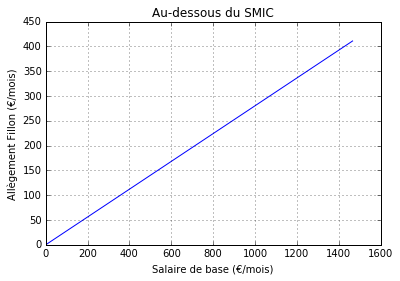

In [13]:
plt.plot(salaire_de_base_under_smic, allegement_fillon_under_smic)

plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Allègement Fillon (€/mois)')
plt.title(u'Au-dessous du SMIC')
plt.grid(True)
plt.show()

In [14]:
smic_mensuel = nb_heures_par_mois_temps_plein * smic_horaire
smic_mensuel

1466.6166666666666

In [15]:
# Au-delà du SMIC mensuel, on suppose que le volume horaire reste fixé à 35 heures,
# et que c'est le salaire horaire qui augmente

scenario_over_smic = tax_benefit_system.new_scenario().init_single_entity(
    axes = [
        dict(
            count = 50,
            min = smic_mensuel,
            max = 5000,
            name = 'salaire_de_base',
            ),
        ],
    period = '2016-01',
    parent1 = dict(
        date_naissance = date_naissance_parent1,
        contrat_de_travail = 0, # temps plein
        allegement_fillon_mode_recouvrement = 1, # anticipe_regularisation_fin_de_periode
        ),
    )



In [ ]:
simulation_over_smic = scenario_over_smic.new_simulation()




In [ ]:
salaire_de_base_over_smic = simulation_over_smic.calculate('salaire_de_base', '2016-01')
salaire_de_base_over_smic



In [ ]:


allegement_fillon_over_smic = simulation_over_smic.calculate('allegement_fillon', '2016-01')
allegement_fillon_over_smic



In [ ]:
from openfisca_core import tools
print(tools.get_trace_tool_link(scenario_over_smic, ['allegement_fillon'], api_url='https://api.openfisca.fr/', trace_tool_url='https://www.openfisca.fr/tools/trace'))


In [ ]:
plt.plot(salaire_de_base_over_smic, allegement_fillon_over_smic)
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Allègement Fillon (€/mois)')
plt.title(u'Au-dessus du SMIC')
plt.grid(True)
plt.show()

In [ ]:
# On crée ici la variable "salaire_de_base" qui est l'enchainement du segment : 0 €- SMIC mensuel et du segment SMIC mensuel - au-delà
# le crochet [:-1] permet d'éviter que l'on ait l'observation "SMIC mensuel" en doublon

salaire_de_base = np.concatenate([salaire_de_base_under_smic[:-1], salaire_de_base_over_smic])

In [ ]:
allegement_fillon = np.concatenate([allegement_fillon_under_smic[:-1], allegement_fillon_over_smic])

In [ ]:
plt.plot(salaire_de_base, allegement_fillon)
# plt.plot(salaire_de_base_under_smic, allegement_fillon_under_smic, label=u'Temps partiel de 0 à 35h/mois')
# plt.plot(salaire_de_base_over_smic, allegement_fillon_over_smic, label=u'Temps plein')
plt.xlabel(u'Salaire de base (€/mois)')
plt.ylabel(u'Allègement Fillon (€/mois)')
plt.title(u'Variation du salaire de base mensuel avec réduction du volume horaire au-dessous du SMIC')
plt.grid(True)
plt.axvline(x=smic_mensuel, color='r', label='SMIC')
plt.legend()
plt.show()